In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import keras

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets  as tfds
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import plot_model, to_categorical
from keras import backend as K
!pip install keras-lookahead
!pip install texthero
import texthero as hero
from texthero import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report,f1_score, confusion_matrix, recall_score, precision_score
from keras_lookahead import Lookahead
from keras.callbacks import LearningRateScheduler

In [61]:
cols = ['EventDescription','IncidentCause','IncidentConsequence', 'Category']
df2 = pd.read_csv('/content/cleaned_incidents1.csv', usecols = cols)
df2 = df2.dropna()
df2['Category'].unique()
df2['Description'] = df2['EventDescription'] + ' ' +  df2['IncidentCause']+ ' ' + df2['IncidentConsequence']



#create a custom cleaning pipeline
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_stopwords
                   , preprocessing.remove_whitespace]
                   #, preprocessing.stem]



#pass the custom_pipeline to the pipeline argument
df2['Description'] = hero.clean(df2['Description'], pipeline = custom_pipeline)


#Label encode the category
le = LabelEncoder()
df2['Category'] = le.fit_transform(df2['Category'].astype(str))
Y = df2['Category'] 


x_train, x_test, y_train, y_test = train_test_split(df2['Description'],Y, 
                                                    test_size=0.25, random_state=0, stratify = Y, shuffle = True)
#print(x_test.shape)
#oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=5)

max_words = 250
max_len = 50

#train data preprocessing
tok = Tokenizer(num_words=max_words,filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" ",)
tok.fit_on_texts(df2['Description'])
sequences = tok.texts_to_sequences(x_train)
print(sequences)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #X_train
print(sequences_matrix.shape)

'''
oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=5)
x_train, y_train = oversample.fit_resample(sequences_matrix, y_train)
print(x_train.shape,y_train.shape)
'''
#For the test data preprocessing

sequences1 = tok.texts_to_sequences(x_test)
sequences_matrix1 = sequence.pad_sequences(sequences1,maxlen=max_len) #X_train
print(sequences_matrix1.shape)



#train and validation split
x_train, x_val, y_train, y_val = train_test_split(sequences_matrix,y_train,
                                                    test_size=0.30, random_state=0, stratify = y_train, shuffle = True)

                                        

[[190, 6, 126, 158, 158, 8, 43, 65, 229, 82, 8, 92, 20, 100, 8, 214, 8, 229, 214, 8, 77, 154, 154, 154, 8, 92, 6], [179, 3, 1, 69, 123, 13, 16, 18, 4, 7, 1, 205, 69, 242, 5, 1, 3, 12, 29, 26, 20, 156, 4, 2, 25, 1], [72, 3, 32, 2, 184, 132, 216, 20, 140, 4, 64, 42, 126, 39, 72, 3, 180, 42, 7, 184, 42, 45, 43, 11, 152, 216, 5, 71, 65, 167, 86, 6, 223, 184, 24, 45, 11, 152, 86, 85, 54, 80, 83, 78, 24, 9, 5, 24, 66, 90, 67, 60], [34, 65, 23, 192, 245, 245, 153, 59, 165, 17, 153, 192, 245, 53, 27, 11, 9, 50, 23], [3, 201, 151, 96, 7, 44, 56, 44, 63, 69, 123, 11, 10, 154, 44, 56, 6, 28, 21], [138, 71, 19, 65, 167, 119, 247, 182, 34, 65, 167, 119, 49, 138, 51, 138, 49, 234, 140, 194, 206, 38, 2, 84, 50, 23], [22, 120, 22, 95, 93, 217, 32, 13, 16, 117, 18, 101, 4, 7, 217, 9, 5, 12, 1, 31, 15, 52, 46, 17, 6, 28, 21], [33, 4, 7, 24, 11, 226, 89, 2, 60, 73, 143, 48, 11, 110, 4, 72, 72, 88, 11, 70, 23, 220, 1, 88, 11, 24, 11, 226, 89, 2, 73, 155, 86, 85, 54, 80, 83, 78, 24, 9, 5, 24, 66, 90, 67, 6

In [62]:
%load_ext tensorboard
#rm -rf ./logs/

units_mul = 80  #tensorflow experimentor
unique_categories = np.unique(Y)
print(unique_categories)
labels_count = len(unique_categories)
dropout = 0.7


def RNN3():
  model = tf.keras.Sequential()
  model.add(Embedding(max_words, units_mul, input_length=x_train.shape[1]))
  model.add(tf.keras.layers.SpatialDropout1D(0.7))

  #model.add(layers.LSTM(units_mul, dropout=dropout, activation='tanh'))
  model.add(layers.Conv1D(units_mul,3,padding='valid',activation='relu',strides=1))
  #model.add(layers.Conv1D(units_mul,3,padding='valid',activation='relu',strides=1))
  model.add(layers.MaxPooling1D(pool_size=2))
  # todo try bidrectional layer again
  model.add(layers.LSTM(units_mul, dropout=dropout,recurrent_dropout=dropout, activation='tanh'))
  #model.add(BatchNormalization())
  model.add(Dense(labels_count, activation='softmax'))
  return model

print(RNN3().summary())


optimiser = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
lk = Lookahead(optimiser, sync_period=5, slow_step=0.5, name = 'Lookahead')

#The step decay learning rate
#Step Decay A typical way is to to drop the learning rate by half every 10 epochs 
#https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1


def step_decay(epoch):
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 10
    alpha = initAlpha *(factor **np.floor((1 + epoch)/dropEvery))
    return float(alpha)


# train model
model = RNN3()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=lk.optimizer,
              metrics=['accuracy'])
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

with tf.device('/device:GPU:0'):
  history = model.fit(x_train,y_train, batch_size=128,
                    epochs=15,callbacks=[LearningRateScheduler(step_decay),tensorboard_callback],
                    validation_data = (x_val,y_val))
#
accr = model.evaluate(sequences_matrix1,y_test)
print(accr[1])

y_pred = model.predict_classes(sequences_matrix1)
print(classification_report(y_test, y_pred))


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 50, 80)            20000     
_________________________________________________________________
spatial_dropout1d_46 (Spatia (None, 50, 80)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 48, 80)            19280     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 24, 80)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dense_48 (Dense)             (None, 15)         

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



              precision    recall  f1-score   support

           0       0.57      0.48      0.53        95
           1       0.75      0.63      0.68        70
           2       0.46      0.38      0.42        47
           3       0.77      0.91      0.84       226
           4       0.66      0.95      0.78       119
           5       0.84      0.85      0.85        96
           6       0.84      0.91      0.87       107
           7       0.00      0.00      0.00         7
           8       0.84      0.70      0.76        37
           9       0.60      0.48      0.54        54
          10       0.89      0.84      0.86       330
          11       0.64      0.34      0.44        82
          12       0.86      0.96      0.90       142
          13       1.00      0.43      0.60         7
          14       0.88      0.89      0.89       203

    accuracy                           0.79      1622
   macro avg       0.71      0.65      0.66      1622
weighted avg       0.78   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

In [ ]:
!pip3 install pycm==3.0
from pycm import *

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.52      0.42      0.47        95
           1       0.75      0.64      0.69        70
           2       0.44      0.23      0.31        47
           3       0.76      0.88      0.82       226
           4       0.75      0.90      0.82       119
           5       0.79      0.92      0.85        96
           6       0.82      0.91      0.86       107
           7       0.00      0.00      0.00         7
           8       0.86      0.86      0.86        37
           9       0.59      0.54      0.56        54
          10       0.92      0.84      0.88       330
          11       0.60      0.48      0.53        82
          12       0.82      0.96      0.88       142
          13       0.00      0.00      0.00         7
          14       0.88      0.89      0.88       203

    accuracy                           0.79      1622
   macro avg       0.63      0.63      0.63      1622
weighted avg       0.78   

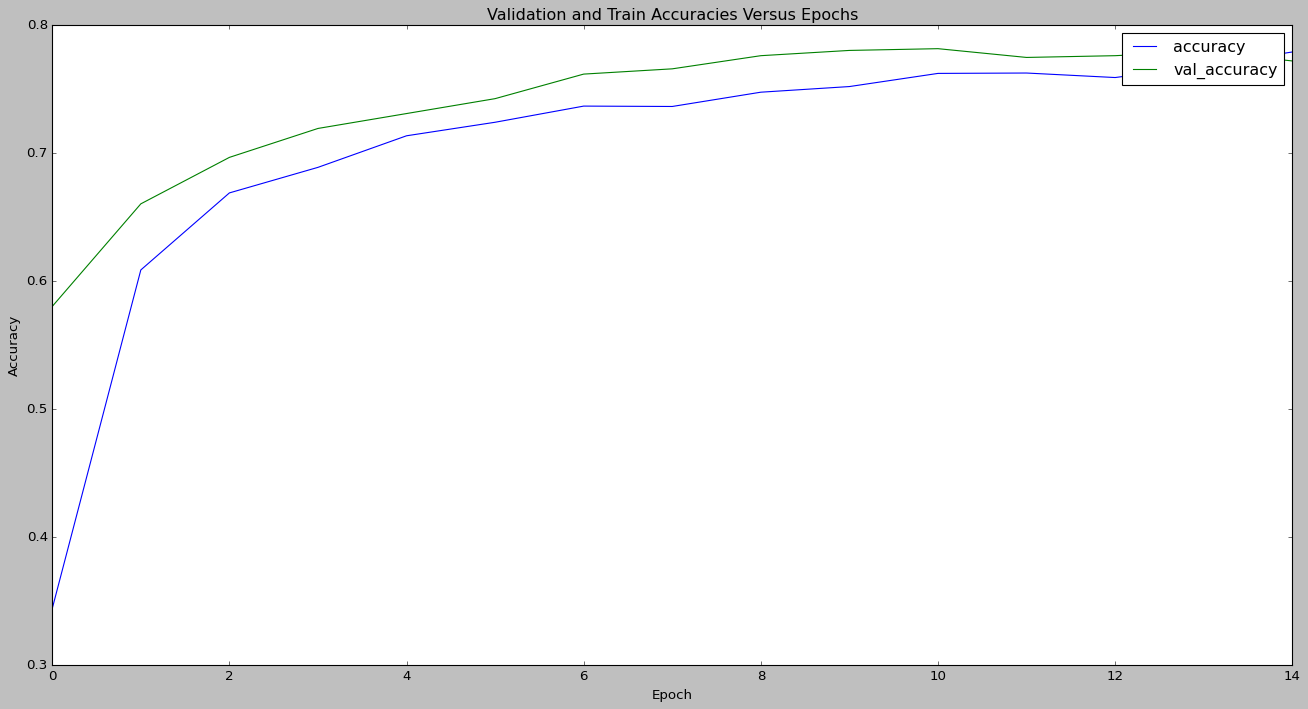

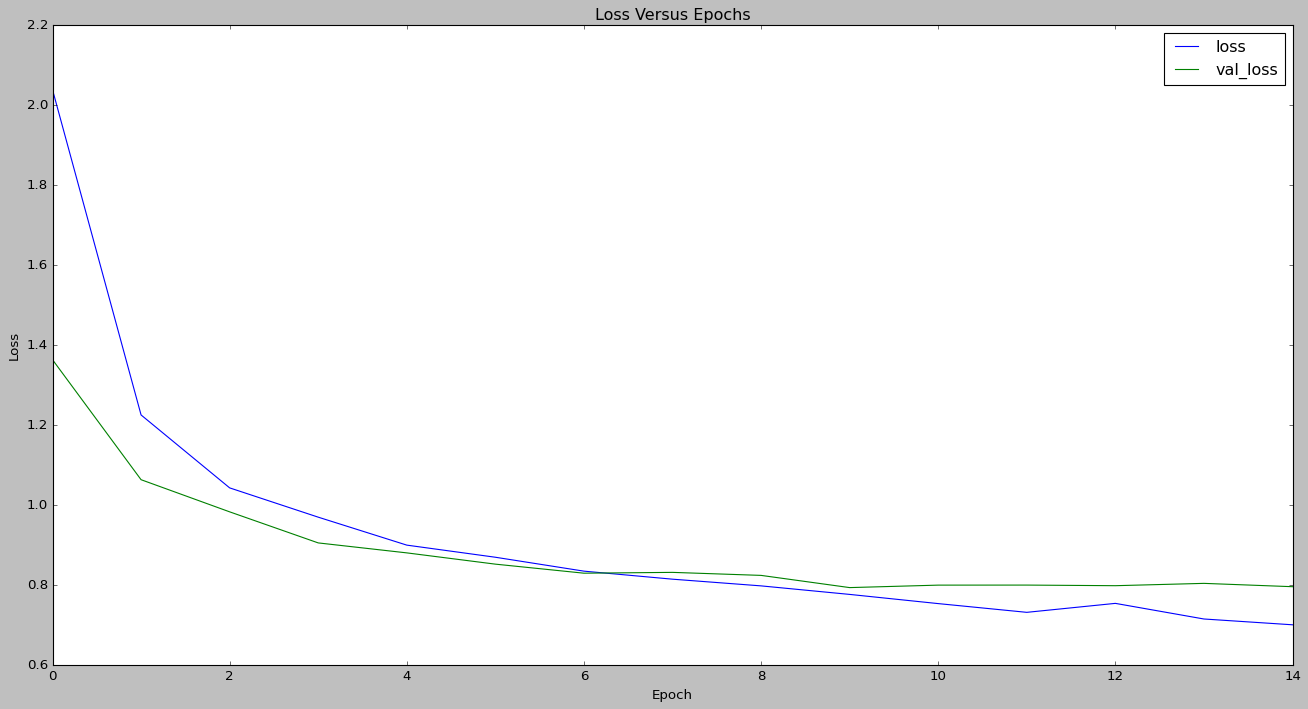

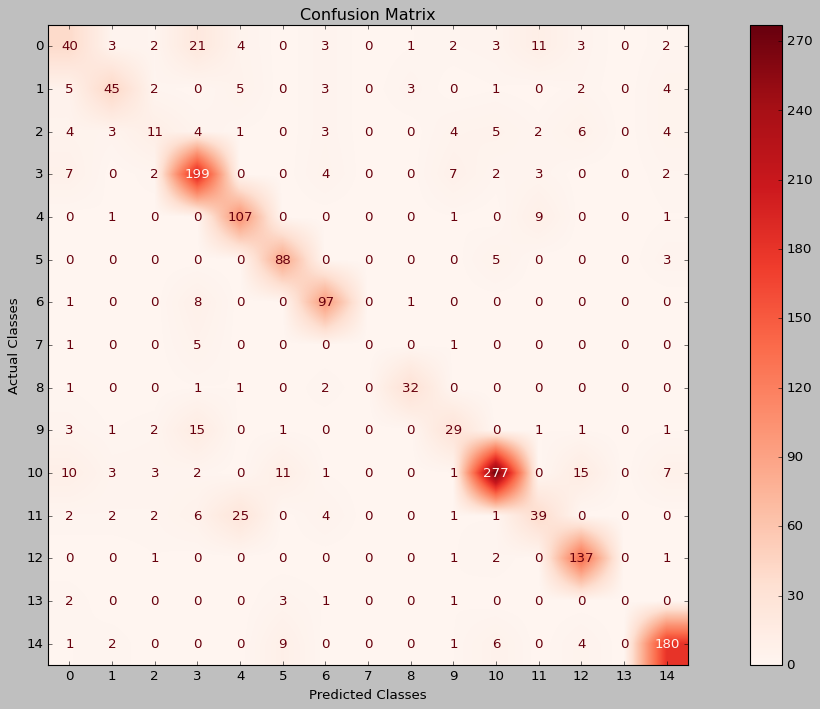

In [58]:
# Accuracy

plt.style.use('classic')
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

def plot_curves(history, model, y_test, y_pred):
  #print confusion matrix and
  print(classification_report(y_test, y_pred))
  print(precision_score(y_test, y_pred, average='micro'))
  print(f1_score(y_test, y_pred, average='micro'))
  print(recall_score(y_test, y_pred, average='micro'))

  #print(confusion_matrix(y_test, y_pred))


  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.title('Validation and Train Accuracies Versus Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Loss
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.title('Loss Versus Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  y_test = y_test.tolist()
  y_pred = y_pred.tolist()
  cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred)
  cm.plot(cmap=plt.cm.Reds,number_label=True,plot_lib="matplotlib")


plot_curves(history,model,y_test,y_pred)

In [ ]:
#Save the model.
'''
from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
with open("model_num.json", "w") as json_file:
  json_file.write('model_json')
model.save_weights('model_weights.h5')
'''

In [ ]:
'''
RNN model was highly overfitted with 5000 max features, 100 input units in convo1D and LSTM, 100 pad sequence length. 

I tried reducing the max features to 250, then reduced the input units of covolutional1D layer 50 80, also reduced the
width of padsequencing to 80 .Then there was significant reduction in overfitting. 


later, I tried adjusting the step decay function where the learning rate decays every 5 epochs to 10 epochs, and increased 
the number of epochs to 15. 

The overfitting was there but couldnt be fully eliminated.

I increased the vaidation split to 30% of the training data (initially it was 20%), 
it improved the prediction of minor classes, but class #7 still has zero prediction. 

tried adding batchnormalization layers after  maxpooling layer  and spatialdropout, 
but no improvement in overfitting condition. 

Dense layers too didnt have a significant impact. 




'''

'\nRNN model was highly overfitted\n\n\n'